
# Assignment 4: Graphs & DenseNets - Kai Ponel & Hannan Mahadik

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CIFAR

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_data = tf.data.Dataset.from_tensor_slices(
    (train_images.astype(np.float32) / 255, train_labels.reshape(-1).astype(np.int32)))
train_data = train_data.shuffle(buffer_size=60000).batch(128)

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.astype(np.float32) / 255, test_labels.reshape(-1).astype(np.int32))).batch(128)

inputs = keras.Input(shape=(32, 32, 3))
print("Shape of Inputs: {} \nData Type of Inputs: {}".format(inputs.shape,inputs.dtype))

170498071/170498071 [==============================] - 2s 0us/step
Shape of Inputs: (None, 32, 32, 3) 
Data Type of Inputs: <dtype: 'float32'>


# -------------------------------------------------------------------------------

# Dense Model

## Some Parameters

In [ ]:
regularizer = tf.keras.regularizers.l2(1e-4)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

optimizer = tf.keras.optimizers.Adam()

In [ ]:
num_blocks = 3
num_layers_per_block = 5
growth_rate = 12
compress_factor = 0.5

num_filters = 16

## Composite Function
Composite function of four consecutive operations:

1.   Batch Normalization
2.   ReLU unit
3.   1x1 Conv for computational efficiency 
4.   3 × 3 convolution

Dropout layer added for generalization



In [ ]:
def composite_function(inputs, num_filters):

    x = layers.BatchNormalization()(inputs)

    x = layers.Activation('relu')(x)

    x = layers.Conv2D(num_filters, kernel_size=1, kernel_initializer='he_normal')(x)

    x = layers.Conv2D(num_filters, kernel_size=3, padding = 'same', kernel_initializer='he_normal')(x)

    x = layers.Dropout(0.2)(x)

    return x

## Transition Layer
Layers between dense blocks:

1.   Batch normalization
2.   1×1 convolutional layer
3.   2×2 average pooling 

Dropout layer added for generalization

In [ ]:
def translayer(inputs, num_filters, theta):

    x = layers.BatchNormalization()(inputs)

    x = layers.Activation('relu')(x)

    # If a dense block contains m feature-maps, we let the following transition layer generate [θm] output feature maps, where 0 < θ ≤1 is referred to as the compression factor. 
    # When θ = 1, the number of feature-maps across transition layers remains unchanged.

    num_feature_maps = inputs.shape[1]

    # print(num_feature_maps)

    x = layers.Conv2D(np.floor(theta * num_feature_maps).astype(int),
                               kernel_size=1, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizer)(x)
    
    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    
    x = layers.Dropout(0.2)(x)

    return x

## Dense Block
To connect outputs from previous layers to following ones

In [ ]:
def dense_block(inputs, num_layers, num_filters, growth_rate):

    for i in range(num_layers): # num_layers is the value of 'l'
        conv_outputs = composite_function(inputs, num_filters)
        inputs = layers.Concatenate()([conv_outputs, inputs])
        num_filters += growth_rate # To increase the number of filters for each layer.

    return inputs, num_filters

## Model
1.   3x3 Conv. 
2.   for-loop to facilitate multiple dense blocks
3.   Transition layer between the blocks
4.   Global avg pooling to get 2D outputs
5.   Dense layer for final classification


In [ ]:
x = layers.Conv2D(num_filters, kernel_size=3, kernel_initializer='he_normal', kernel_regularizer=regularizer)(inputs)

for i in range(num_blocks):
    x, num_filters = dense_block(x, num_layers_per_block, num_filters, growth_rate)
    if (i != num_blocks - 1):
      x = translayer(x, num_filters, compress_factor)

## GlobalAveragePooling2D layer ensures that the outputs are 2D
x = layers.GlobalAveragePooling2D()(x)  

x = layers.Dense(10)(x) 
outputs = layers.Activation('softmax')(x)

## Train Model

In [ ]:
model = tf.keras.models.Model(inputs , outputs)
model.compile(optimizer = optimizer, loss = loss_fn, metrics = metrics)

### Model with Transition layer before global pooling

In [ ]:
history = model.fit(train_images, train_labels, epochs=30, batch_size=128, validation_data=(test_images, test_labels))

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


391/391 [==============================] - 71s 153ms/step - loss: 1.7600 - sparse_categorical_accuracy: 0.3665 - val_loss: 1.8093 - val_sparse_categorical_accuracy: 0.4336
Epoch 2/30
391/391 [==============================] - 57s 146ms/step - loss: 1.3468 - sparse_categorical_accuracy: 0.5179 - val_loss: 1.3641 - val_sparse_categorical_accuracy: 0.5381
Epoch 3/30
391/391 [==============================] - 57s 146ms/step - loss: 1.2032 - sparse_categorical_accuracy: 0.5732 - val_loss: 1.3241 - val_sparse_categorical_accuracy: 0.5802
Epoch 4/30
391/391 [==============================] - 57s 145ms/step - loss: 1.1194 - sparse_categorical_accuracy: 0.6109 - val_loss: 1.5566 - val_sparse_categorical_accuracy: 0.5164
Epoch 5/30
391/391 [==============================] - 57s 145ms/step - loss: 1.0485 - sparse_categorical_accuracy: 0.6388 - val_loss: 1.1066 - val_sparse_categorical_accuracy: 0.6449
Epoch 6/30
391/391 [==============================] - 57s 145ms/step - loss: 0.9935 - sparse_cat

### Model Training without the final transition layer before global pooling

In [ ]:
history2 = model.fit(train_images, train_labels, epochs=30, batch_size=128, validation_data=(test_images, test_labels))

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


391/391 [==============================] - 65s 148ms/step - loss: 1.7822 - sparse_categorical_accuracy: 0.3747 - val_loss: 1.3910 - val_sparse_categorical_accuracy: 0.4984
Epoch 2/30
391/391 [==============================] - 57s 147ms/step - loss: 1.2709 - sparse_categorical_accuracy: 0.5408 - val_loss: 1.2449 - val_sparse_categorical_accuracy: 0.5816
Epoch 3/30
391/391 [==============================] - 55s 141ms/step - loss: 1.0660 - sparse_categorical_accuracy: 0.6221 - val_loss: 1.2479 - val_sparse_categorical_accuracy: 0.6109
Epoch 4/30
391/391 [==============================] - 55s 141ms/step - loss: 0.9508 - sparse_categorical_accuracy: 0.6655 - val_loss: 1.1628 - val_sparse_categorical_accuracy: 0.6314
Epoch 5/30
391/391 [==============================] - 57s 147ms/step - loss: 0.8664 - sparse_categorical_accuracy: 0.6975 - val_loss: 1.0147 - val_sparse_categorical_accuracy: 0.6803
Epoch 6/30
391/391 [==============================] - 55s 141ms/step - loss: 0.7999 - sparse_cat

## Model Architecture

### Model Summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 30, 30, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 30, 30, 16)   0           ['batch_normalization[0][0]']

### Graph of Model

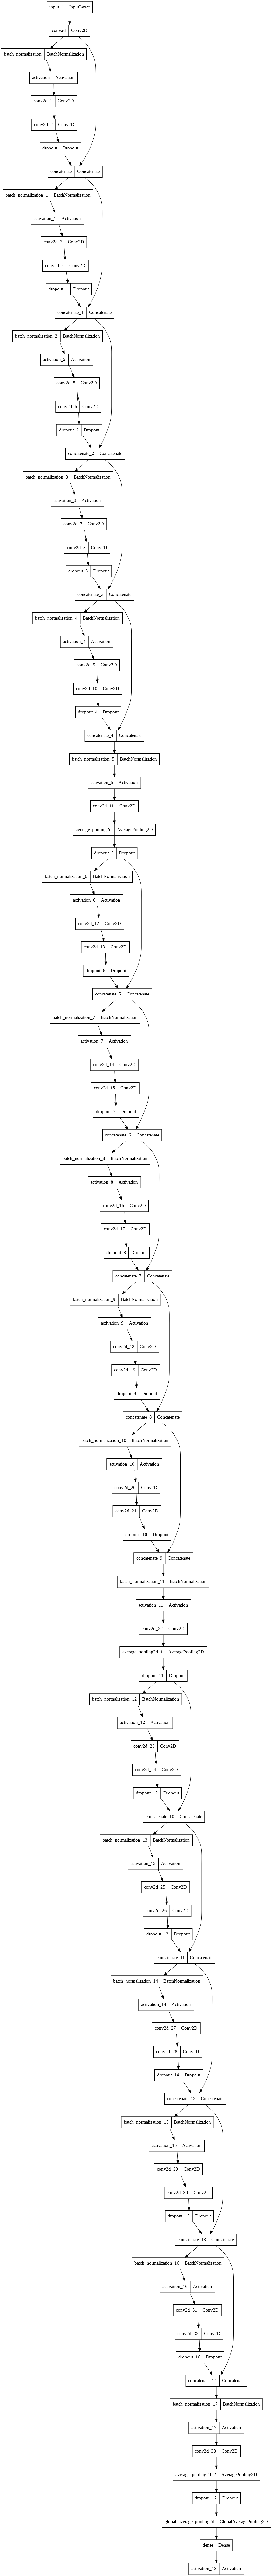

In [ ]:
keras.utils.plot_model(model)

### Graph of Model using SVG

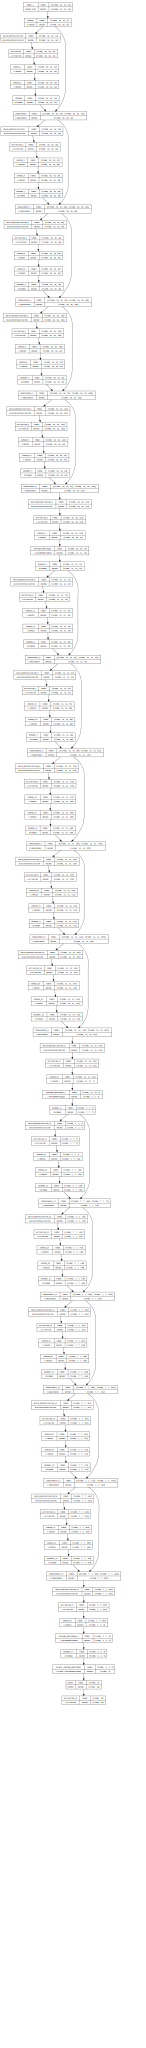

In [ ]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot',format='svg'))

### Graph of Model using SVG (Direct connection from last dense block to global pooling)

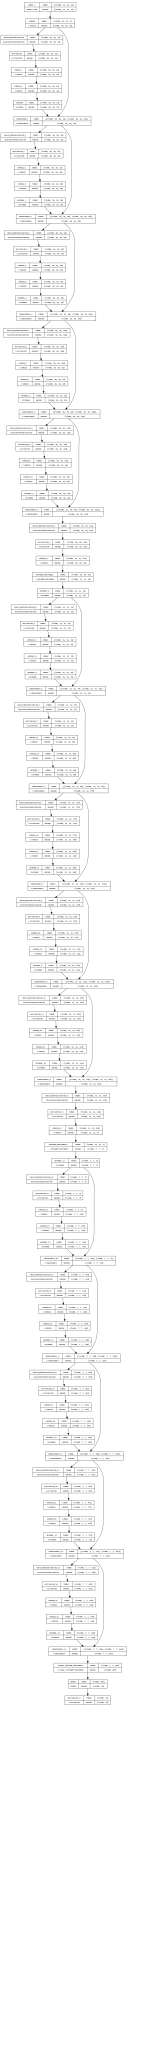

In [ ]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot',format='svg'))

## Evaluation

### Transition layer before FC-layer

313/313 - 3s - loss: 0.7284 - sparse_categorical_accuracy: 0.8161 - 3s/epoch - 11ms/step


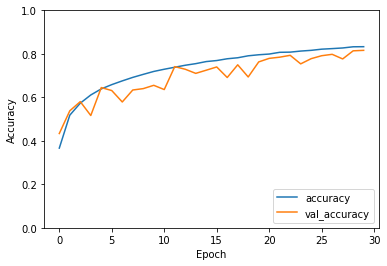

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

### Direct connection from Dense to FC-layer

313/313 - 4s - loss: 0.5897 - sparse_categorical_accuracy: 0.8336 - 4s/epoch - 12ms/step


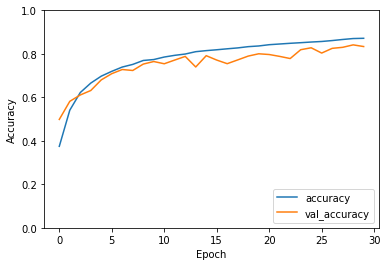

In [ ]:
plt.plot(history2.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history2.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

# -------------------------------------------------------------------------------

# Tf.Function


## Imports

In [ ]:
from google.colab import drive; 
drive.mount('/content/drive/', force_remount=True)

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from datasets import MNISTDataset

Mounted at /content/drive/


## Load MNIST Dataset 

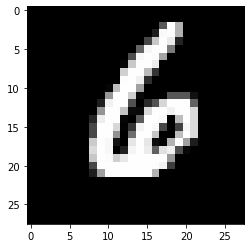

6


In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# we can look at any of the images and the corresponding labels
# say, image no. 155
plt.imshow(train_images[155], cmap="Greys_r")
plt.show()
print(train_labels[155])

# images are "flattened" into vectors
data = MNISTDataset(train_images.reshape([-1, 28*28]), train_labels, 
                    test_images.reshape([-1, 28*28]), test_labels,
                    batch_size=128)

## Convert Images to NP Arrays

In [ ]:
train_images = train_images.astype(np.float32) / 255
test_images = test_images.astype(np.float32) / 255


## Deep Model

In [ ]:
# Module - A named container for tf.Variables
class mlp(tf.Module):
  
  def __init__(self, units_per_layer, activation_function, name=None):

    # initialization
    self.activation_function = activation_function
    self.layers = len(units_per_layer) 
    self.params = {}

    # weight and bias initialization for the hidden layers
    for layer in range(1, self.layers):

      # Input of hidden layer 2 = output of hidden layer 1
      input_size = units_per_layer[layer - 1] 
      output_size = units_per_layer[layer] 

      # Weights cannot be zero => Initialized with values close to zero
      weights = "w{}".format(layer)
      self.params[weights] = tf.Variable(
          np.random.randn(input_size, output_size).astype(np.float32) * 0.01, 
          name = weights
      )

      # Bias initialized as zero (same as 'shallow' model) 
      bias = "b{}".format(layer)
      self.params[bias] = tf.Variable(
          np.zeros(output_size, dtype = np.float32), 
          name = bias
      )


  def __call__(self, x):

    logits = self.logits(x)

    # Logits are 'pre-softmax values' => apply softmax activation function
    activation_function = tf.nn.softmax(logits, axis = 1)

    return activation_function

  @tf.function
  def logits(self, x):
    activation = x

    # Assign each of the hidden layers with an input and activation function
    for layer in range(1, self.layers-1):
      weights, bias = "w{}".format(layer), "b{}".format(layer)
      z = activation @ self.params[weights] + self.params[bias]
      activation = self.activation_function(z)

    # Output layer 
    weights, bias = "w{}".format(self.layers-1), "b{}".format(self.layers-1)
    logits = activation @ self.params[weights] + self.params[bias]

    return logits

## Model Specification

In [ ]:
# Function for easy customization of number of units, layers, and activation function
def results(x):

  no_of_units = x['units']
  no_of_layers = x['layers']
  
  model = [28*28] + [no_of_units for _ in range(no_of_layers)] + [10]

  result = train(mlp(model, x['activation_function']), data, 
                 training_steps = x['train_steps'], 
                 learning_rate = x['learning_rate'])

## Training (MLP)

In [ ]:
def train(model, data, training_steps, learning_rate):

  for step in range(1, training_steps + 1):
    image_batch, label_batch = data.next_batch()

    with tf.GradientTape() as tape:
      logits = model.logits(image_batch)
      xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
          logits=logits, labels=label_batch))

    grads = tape.gradient(xent, model.variables)

    # Perform one step of gradient descent
    for (variable, gradient) in zip(model.variables, grads):
      variable.assign_sub(learning_rate * gradient)
     
    # every so often we print loss/accuracy 
    if not step % 100:
      preds = tf.argmax(logits, axis=1, output_type=tf.int32)
      acc = tf.reduce_mean(tf.cast(tf.equal(preds, label_batch),tf.float32))

      print("Step {}. Batch loss: {} Batch accuracy: {}".format(step+1, xent, acc))

## Test (Deep Model)

In [ ]:
x = {'layers':3, 'units':300, 'activation_function':tf.nn.relu,'train_steps':10000, 'learning_rate':0.1} 
results(x)
#                           With            /  Without   ("Slow down")
# 1layer@100Units@2000:     16.87           /  17.98     +6.5%
# 2layers@100Units@2000:    17.2            /  18.9      +9.88%
# 3layers@300Units@10000:   173.129, 171.6  /  190.66    +10.6%
# "If you can get this to work on one of your previous models and actually get a speedup, you get a cookie. :)" 

Step 101. Batch loss: 2.296966791152954 Batch accuracy: 0.1484375
Step 201. Batch loss: 2.301478624343872 Batch accuracy: 0.1015625
Step 301. Batch loss: 2.3005669116973877 Batch accuracy: 0.1015625
Starting new epoch...
Step 401. Batch loss: 2.2992959022521973 Batch accuracy: 0.125
Step 501. Batch loss: 2.2977817058563232 Batch accuracy: 0.1484375
Step 601. Batch loss: 2.287548303604126 Batch accuracy: 0.1484375
Step 701. Batch loss: 2.155606269836426 Batch accuracy: 0.203125
Step 801. Batch loss: 1.6611833572387695 Batch accuracy: 0.3359375
Starting new epoch...
Step 901. Batch loss: 1.262606143951416 Batch accuracy: 0.484375
Step 1001. Batch loss: 0.9689759016036987 Batch accuracy: 0.6328125
Step 1101. Batch loss: 0.7866740226745605 Batch accuracy: 0.765625
Step 1201. Batch loss: 0.5511610507965088 Batch accuracy: 0.84375
Starting new epoch...
Step 1301. Batch loss: 0.4919147789478302 Batch accuracy: 0.828125
Step 1401. Batch loss: 0.3487643599510193 Batch accuracy: 0.8671875
Step 1

# -------------------------------------------------------------------------------

# Bonus(incomplete)

## Sequential Dense Model

Same hyper parameters as the previous model

In [ ]:
class Dense_block(layers.Layer):

  def __init__(self, num_layers_per_block, num_filters, growth_rate):
    self.num_layers_per_block = num_layers_per_block
    self.num_filters = num_filters
    self.growth_rate = growth_rate
    super(DenseLayer, self).__init__()

  def build(self, input_shape):


  def call(self, inputs):
    return

In [ ]:
class Compose(layers.Layer):

  def __init__(self, num_filters, growth_rate):
    self.num_filters = num_filters
    self.growth_rate = growth_rate
    super(DenseLayer, self).__init__()

  def build(self, input_shape):


  def call(self, inputs):
    return

In [ ]:
class Translayer(layers.Layer):

  def __init__(self, compress_factor):
    self.compress_factor) = compress_factor)
    super(DenseLayer, self).__init__()

  def build(self, input_shape):


  def call(self, inputs):
    return

In [ ]:
S_model = tf.keras.models.Sequential([

  keras.Input(shape=(32, 32, 3)),
  
  # Initial Conv.
  layers.Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizer),

  # Pass through a dense block
  DenseBlock(num_layers_per_block, num_filters, growth_rate),
  layers.Dropout(0.2),

  # Transition layer
  Translayer(compress_factor),
  layers.Dropout(0.2),

  # Next dense block
  DenseBlock(num_layers_per_block, num_filters, growth_rate),
  layers.Dropout(0.2),

  layers.GlobalAveragePooling2D(),
  layers.Dense(10, activation='softmax')
])


In [ ]:
S_model.compile(optimizer = optimizer, loss = loss_fn, metrics = metrics)

In [ ]:
history3 = S_model.fit(train_images, train_labels, epochs=30, batch_size=128, validation_data=(test_images, test_labels))

### Evaluation

In [ ]:
plt.plot(history3.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history3.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

## -------------------------------------------------------------------------------

## Tensorboard (Bonus)

In [ ]:
from google.colab import drive; 
drive.mount('/content/drive/', force_remount=True)

import os
os.chdir("/content/drive/MyDrive/ColabNotebooks/Intro to Deep Learning")

%load_ext tensorboard
# %reload_ext tensorboard

%tensorboard --logdir '/content/drive/MyDrive/ColabNotebooks/IDL_Hannan_Kai/Task 4/logs'

Mounted at /content/drive/


# Random:

## Model on MNIST

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 64)                50240     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


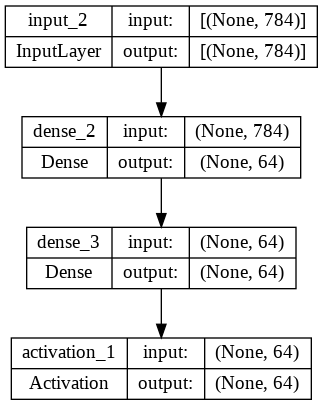

In [ ]:
inputs = keras.Input(shape=(784,))

dense = layers.Dense(64, activation="relu")
x = dense(inputs)

x = layers.Dense(64, activation="relu")(x)
outputs = layers.Activation('softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="my_model")

model.summary()

keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

train_images = train_images.reshape(60000, 784).astype("float32") / 255
test_images = test_images.reshape(10000, 784).astype("float32") / 255

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

history = model.fit(train_images, train_labels, batch_size=64, epochs=2, validation_split=0.2)

test_scores = model.evaluate(test_images, test_labels, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/2
750/750 [==============================] - 3s 3ms/step - loss: 0.8148 - accuracy: 0.8185 - val_loss: 0.6105 - val_accuracy: 0.8601
Epoch 2/2
750/750 [==============================] - 2s 3ms/step - loss: 0.5891 - accuracy: 0.8619 - val_loss: 0.5716 - val_accuracy: 0.8687
313/313 - 1s - loss: 0.5681 - accuracy: 0.8665 - 536ms/epoch - 2ms/step
Test loss: 0.5681095123291016
Test accuracy: 0.8665000200271606


## function_al.ipynb (Notebook from the exercise)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

170498071/170498071 [==============================] - 14s 0us/step
[6]


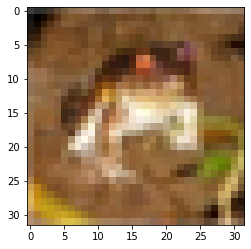

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
print(train_labels[0])
plt.imshow(train_images[0])
plt.show()

train_data = tf.data.Dataset.from_tensor_slices(
    (train_images.astype(np.float32) / 255, train_labels.reshape(-1).astype(np.int32)))
train_data = train_data.shuffle(buffer_size=60000).batch(128).repeat()

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.astype(np.float32) / 255, test_labels.reshape(-1).astype(np.int32))).batch(128)

In [ ]:
# example: two (basic) inception blocks
# TODO: add 1x1 convs ;)
inputs = layers.Input((32, 32, 3))


conv1_1 = layers.Conv2D(32, 1, activation=tf.nn.relu, padding="same",
                                 name="conv1_1x1")(inputs)
conv1_3 = layers.Conv2D(32, 3, activation=tf.nn.relu, padding="same",
                                 name="conv1_3x3")(inputs)
conv1_5 = layers.Conv2D(32, 5, activation=tf.nn.relu, padding="same",
                                 name="conv1_5x5")(inputs)
pool1 = layers.MaxPool2D(3, 1, padding="same", name="pool1")(inputs)

concat1 = layers.concatenate([conv1_1, conv1_3, conv1_5, pool1])
downscale1 = layers.MaxPool2D(2, padding="same", name="downscale1")(concat1)


conv2_1 = layers.Conv2D(64, 1, activation=tf.nn.relu, padding="same",
                                 name="conv2_1x1")(downscale1)
conv2_3 = layers.Conv2D(64, 3, activation=tf.nn.relu, padding="same",
                                 name="conv2_3x3")(downscale1)
conv2_5 = layers.Conv2D(64, 5, activation=tf.nn.relu, padding="same",
                                 name="conv2_5x5")(downscale1)
pool2 = layers.MaxPool2D(3, 1, padding="same", name="pool2")(downscale1)

concat2 = layers.concatenate([conv2_1, conv2_3, conv2_5, pool2])
downscale2 = layers.MaxPool2D(2, padding="same", name="downscale2")(concat2)

flat = layers.Flatten()(downscale2)
out = layers.Dense(10)(flat)

model = tf.keras.Model(inputs, out, name="inception")


optimizer = tf.optimizers.Adam()

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

accuracy_metric = tf.metrics.SparseCategoricalAccuracy()

# note that functional models are built immediately, assuming we are giving
# an input shape
print(model.summary())

Model: "inception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_1x1 (Conv2D)             (None, 32, 32, 32)   128         ['input_1[0][0]']                
                                                                                                  
 conv1_3x3 (Conv2D)             (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv1_5x5 (Conv2D)             (None, 32, 32, 32)   2432        ['input_1[0][0]']                
                                                                                          

In [ ]:
# basic training loops can be done like this
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_metric])

In [ ]:
# we could also NOT repeat the train_data set, then one epoch = one pass over the full dataset
# fit has many other arguments and we can also pass "callbacks" that do other stuff besides training
model.fit(train_data, steps_per_epoch=1000, epochs=2, validation_data=test_data)

Epoch 1/2
1000/1000 [==============================] - 29s 20ms/step - loss: 1.1896 - sparse_categorical_accuracy: 0.5852 - val_loss: 0.9583 - val_sparse_categorical_accuracy: 0.6681
Epoch 2/2
1000/1000 [==============================] - 19s 19ms/step - loss: 0.8126 - sparse_categorical_accuracy: 0.7222 - val_loss: 0.8505 - val_sparse_categorical_accuracy: 0.7075


In [ ]:
# evaluate test loss and metrics
model.evaluate(test_data)

In [ ]:
# "predict" on new input (i.e. give model outputs)
logits_on_test_set = model.predict(test_data)

79/79 [==============================] - 1s 7ms/step


In [ ]:
logits_on_test_set

array([[ -4.8852754 ,  -5.0105133 ,  -4.938061  , ...,  -7.0745387 ,
         -1.3613285 ,  -4.908318  ],
       [  0.86277413,   3.8289955 ,  -5.5994797 , ...,  -8.409488  ,
          7.5522027 ,  -1.2047795 ],
       [  1.6416675 ,  -0.3099627 ,  -2.689053  , ...,  -4.4598074 ,
          1.3012114 ,  -1.9014057 ],
       ...,
       [ -7.1441174 , -13.204547  ,   0.41058838, ...,  -1.8116013 ,
         -8.652203  , -11.221478  ],
       [ -2.1878138 ,   0.1583644 ,  -4.579676  , ...,  -4.8025556 ,
         -5.693144  ,  -7.836763  ],
       [ -6.1993337 ,  -3.914852  ,  -4.0230813 , ...,   3.8146482 ,
         -6.4280515 ,  -5.8671875 ]], dtype=float32)

In [ ]:
# another example: a residual block
inputs = layers.Input((32, 32, 3))

initial_conv = layers.Conv2D(32, 5, activation=tf.nn.relu, padding="same")(inputs)

conv1_1 = layers.Conv2D(32, 5, activation=tf.nn.relu, padding="same")(initial_conv)
conv1_2 = layers.Conv2D(32, 5, padding="same")(conv1_1)

out1 = tf.nn.relu(conv1_2 + initial_conv)

# another one?
# problem: input and output need to have the same size
# so we can neither pool nor change the number of filters
# if we want do that, we have to add a transformation to the residual (e.g. 1x1 conv)
conv2_1 = layers.Conv2D(32, 5, activation=tf.nn.relu, padding="same")(out1)
conv2_2 = layers.Conv2D(32, 5, padding="same")(conv2_1)

out2 = tf.nn.relu(conv2_2 + out1)


# here's an example of that transformation
conv3_1 = layers.Conv2D(64, 5, strides=2, activation=tf.nn.relu, padding="same")(out2)
conv3_2 = layers.Conv2D(64, 5, padding="same")(conv3_1)

shortcut_transform = layers.Conv2D(64, 1, strides=2)(out2)
out3 = tf.nn.relu(conv3_2 + shortcut_transform)


flat = layers.Flatten()(out3)
logits = layers.Dense(10)(flat)

model = tf.keras.Model(inputs, logits)


optimizer = tf.optimizers.Adam()

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

train_acc_metric = tf.metrics.SparseCategoricalAccuracy()

print(model.summary())


# NOTE!!
# writing a model like this is not a great idea as the variable names become
# very confusing and it's easy to make mistakes.
# better to wrap a residual block into a function, e.g. like this
def residual_block(inputs, filters):
    conv1 = layers.Conv2D(filters, 5, activation=tf.nn.relu, padding="same")(inputs)
    conv2 = layers.Conv2D(filters, 5, padding="same")(conv1)

    return tf.nn.relu(conv2 + inputs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   2432        ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   25632       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 32)   25632       ['conv2d_1[0][0]']               
                                                                                              

In [ ]:
# stereotypical train-step-with-function-annotation

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(images)
        xent = loss_fn(labels, logits)

    variables = model.trainable_variables
    gradients = tape.gradient(xent, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return xent, logits


In [ ]:
train_steps = 2000

start = time.time()
for step, (img_batch, lbl_batch) in enumerate(train_data):
    if step > train_steps:
        break

    xent, logits = train_step(img_batch, lbl_batch)

    if not step % 100:
        train_acc_metric(lbl_batch, logits)
        acc = train_acc_metric.result()
        print("Loss: {} Accuracy: {}".format(xent, acc))
        train_acc_metric.reset_states()

        stop = time.time()
        print("took {} seconds\n".format(stop-start))
        start = time.time()


Loss: 2.324094295501709 Accuracy: 0.1015625
took 0.9701681137084961 seconds

Loss: 1.5908153057098389 Accuracy: 0.46875
took 3.388998031616211 seconds

Loss: 1.4263615608215332 Accuracy: 0.53125
took 3.427971124649048 seconds

Loss: 1.3625473976135254 Accuracy: 0.484375
took 3.428708791732788 seconds

Loss: 1.167976975440979 Accuracy: 0.6015625
took 3.8800415992736816 seconds

Loss: 0.9897753000259399 Accuracy: 0.671875
took 3.450786828994751 seconds

Loss: 1.0315005779266357 Accuracy: 0.6484375
took 3.4392151832580566 seconds

Loss: 1.0356593132019043 Accuracy: 0.640625
took 3.4525234699249268 seconds

Loss: 0.8190323114395142 Accuracy: 0.734375
took 3.474116086959839 seconds

Loss: 0.8558670878410339 Accuracy: 0.671875
took 3.4674770832061768 seconds

Loss: 0.7590165138244629 Accuracy: 0.7265625
took 3.487287998199463 seconds

Loss: 0.8964657783508301 Accuracy: 0.7265625
took 3.476032018661499 seconds

Loss: 0.8262084126472473 Accuracy: 0.703125
took 3.484928846359253 seconds

Loss: 

In [ ]:
test_acc_metric = tf.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, model(img_batch))

test_acc_metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.7005>